In [41]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split


In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter

from torchviz import make_dot

class StackedLSTM_MultiPooling(nn.Module):
    def __init__(self, input_size=12, hidden_size=128, num_layers=3, num_classes=2, dropout=0.5):
        """
        Args:
            input_size (int): Number of input features per time step.
            hidden_size (int): Hidden dimension for each LSTM layer.
            num_layers (int): Number of LSTM layers.
            num_classes (int): Number of output classes.
            dropout (float): Dropout rate applied in LSTM and classifier.
        """
        super(StackedLSTM_MultiPooling, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size

       
        self.lstm_layers = nn.ModuleList()
        for i in range(num_layers):
            curr_input_size = input_size if i == 0 else hidden_size
            self.lstm_layers.append(
                nn.LSTM(input_size=curr_input_size, hidden_size=hidden_size,
                        num_layers=1, batch_first=True, dropout=dropout)
            )

        # Total feature dimension for classification is: num_layers * hidden_size * 2 (for mean and max pooling).
        pooled_feature_size = num_layers * hidden_size * 2

       
        self.classifier = nn.Sequential(
            nn.Linear(pooled_feature_size, hidden_size * 2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size * 2, num_classes)
        )
        
        # Manual dropout between LSTM layers .
        self.manual_dropout = nn.Dropout(dropout)
    
    def pool_outputs(self, lstm_output):
        """Helper function to perform mean and max pooling."""
        mean_pool = lstm_output.mean(dim=1)  # Shape: (batch, hidden_size)
        max_pool, _ = lstm_output.max(dim=1)  # Shape: (batch, hidden_size)
        return torch.cat([mean_pool, max_pool], dim=1)  # Shape: (batch, hidden_size * 2)
    
    def forward(self, x, return_intermediates=False):
        """
        Args:
            x (Tensor): Input tensor of shape (batch, sequence_length, input_size).
            return_intermediates (bool): If True, returns intermediate pooled outputs.
        Returns:
            logits (Tensor): Class logits of shape (batch, num_classes).
            intermediates (dict, optional): Dictionary with pooled outputs from each layer.
        """
        pooled_outputs = {}  

        for i, lstm in enumerate(self.lstm_layers):
            out, _ = lstm(x)
            # Apply manual dropout between layers.
            out = self.manual_dropout(out)
            
            pooled = self.pool_outputs(out)
            pooled_outputs[f"LSTM Layer {i+1}"] = pooled

            # Set output as the input to the next LSTM.
            x = out

        
        final_representation = torch.cat(list(pooled_outputs.values()), dim=1)
        logits = self.classifier(final_representation)
        
        if return_intermediates:
            return logits, pooled_outputs
        return logits

In [47]:
data = torch.load('/kaggle/input/ecg-data/ecg_dataset.pt')
X = data['X']  # Shape: (samples, channels, sequence_length)
y = data['y']  # Shape: (samples,)

# Normalize the data
mean = X.mean(dim=(0, 2), keepdim=True)
std = X.std(dim=(0, 2), keepdim=True)
X = (X - mean) / std

# Reshape X to (samples, sequence_length, channels)
X = X.permute(0, 2, 1)

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

batch_size = 32
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=batch_size)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size)


<ipython-input-47-fb0efc885bae>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load('/kaggle/input/ecg-data/ecg_dataset.pt')


In [51]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = StackedLSTM_MultiPooling(input_size=12, hidden_size=64, num_layers=2, num_classes=2, dropout=0.3).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0004)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Epoch 1/30, Train Loss: 0.6499, Validation Loss: 0.6177, Validation Accuracy: 0.7275
Epoch 2/30, Train Loss: 0.5280, Validation Loss: 0.5022, Validation Accuracy: 0.7969
Epoch 3/30, Train Loss: 0.4683, Validation Loss: 0.4775, Validation Accuracy: 0.7995
Epoch 4/30, Train Loss: 0.4523, Validation Loss: 0.4632, Validation Accuracy: 0.8021
Epoch 5/30, Train Loss: 0.4203, Validation Loss: 0.4586, Validation Accuracy: 0.7789
Epoch 6/30, Train Loss: 0.4060, Validation Loss: 0.4449, Validation Accuracy: 0.7969
Epoch 7/30, Train Loss: 0.3821, Validation Loss: 0.4247, Validation Accuracy: 0.8123
Epoch 8/30, Train Loss: 0.3751, Validation Loss: 0.4624, Validation Accuracy: 0.7943
Epoch 9/30, Train Loss: 0.3619, Validation Loss: 0.4118, Validation Accuracy: 0.8175
Epoch 10/30, Train Loss: 0.3475, Validation Loss: 0.3993, Validation Accuracy: 0.8226
Epoch 11/30, Train Loss: 0.3233, Validation Loss: 0.3957, Validation Accuracy: 0.8252
Epoch 12/30, Train Loss: 0.3173, Validation Loss: 0.3885, Valid

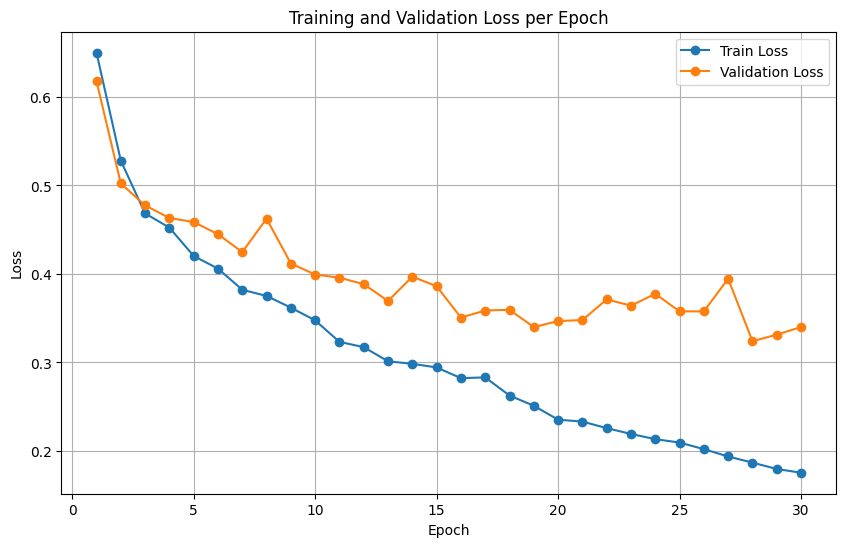

In [ ]:
import matplotlib.pyplot as plt

train_losses = []
val_losses = []

num_epochs = 30
for epoch in range(num_epochs):
   
    model.train()
    running_train_loss = 0.0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        # Multiply loss by the batch size to sum the loss across all samples in the batch.
        running_train_loss += loss.item() * X_batch.size(0)


    epoch_train_loss = running_train_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)

  
    model.eval()
    running_val_loss = 0.0
    correct = 0

    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            running_val_loss += loss.item() * X_batch.size(0)

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == y_batch).sum().item()

    epoch_val_loss = running_val_loss / len(val_loader.dataset)
    val_losses.append(epoch_val_loss)
    val_accuracy = correct / len(val_loader.dataset)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_train_loss:.4f}, '
          f'Validation Loss: {epoch_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')


# Plotting Loss Curves

plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss', marker='o')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss per Epoch')
plt.legend()
plt.grid(True)
plt.show()


In [53]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

model.eval()
test_loss = 0.0
correct = 0

all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)  # outputs shape: (batch, num_classes)
        loss = criterion(outputs, y_batch)
        test_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        correct += (predicted == y_batch).sum().item()

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())

        probs = torch.softmax(outputs, dim=1)
        all_probs.extend(probs[:, 1].cpu().numpy())

test_loss /= len(test_loader.dataset)
test_accuracy = correct / len(test_loader.dataset)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

# Compute additional metrics using scikit-learn:
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)  # recall is equivalent to sensitivity
f1 = f1_score(all_labels, all_preds)
auc = roc_auc_score(all_labels, all_probs)

# Compute confusion matrix for specificity.
# Confusion matrix returns: [[TN, FP], [FN, TP]]
cm = confusion_matrix(all_labels, all_preds)
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall (Sensitivity): {recall:.4f}')
print(f'Specificity: {specificity:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'AUC: {auc:.4f}')


Test Loss: 0.0114, Test Accuracy: 0.8615
Accuracy: 0.8615
Precision: 0.8824
Recall (Sensitivity): 0.7595
Specificity: 0.9310
F1 Score: 0.8163
AUC: 0.9248


| Index | Model                    | Test Loss | Test Accuracy | Accuracy | Precision | Sensitivity (Recall) | Specificity | F1 Score | AUC   | Total Trainable Parameters |
|-------|--------------------------|-----------|---------------|----------|-----------|----------------------|-------------|----------|-------|----------------------------|
| 1     | StackedLSTM_MultiPooling | 0.0114    | 0.8615        | 0.8615   | 0.8824    | 0.7595               | 0.9310      | 0.8163   | 0.9248| 534,274                    |


Final logits shape: torch.Size([32, 2])
LSTM Layer 1 pooled output shape: torch.Size([32, 256])
LSTM Layer 2 pooled output shape: torch.Size([32, 256])
LSTM Layer 3 pooled output shape: torch.Size([32, 256])
Parameter counts: {'LSTM Layer 1': 72704, 'LSTM Layer 2': 132096, 'LSTM Layer 3': 132096, 'Classifier': 197378}


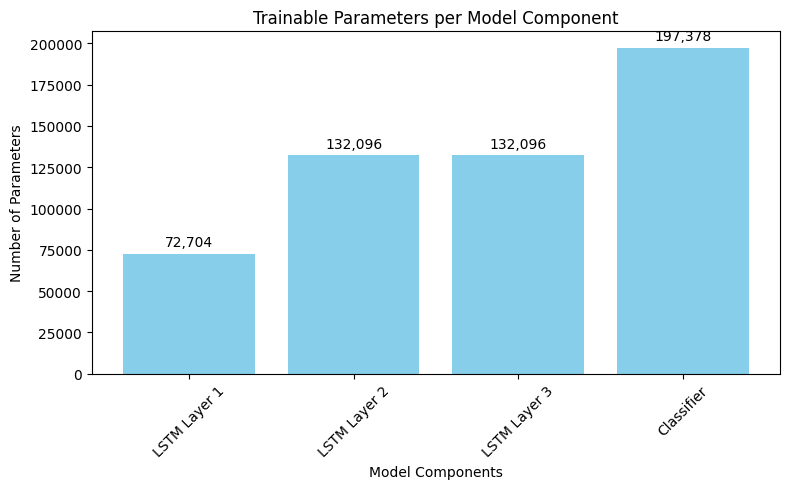

In [56]:

def count_model_parameters(model):
    """
    Counts the number of trainable parameters in each major component of the model.
    
    Returns:
        param_dict (dict): A dictionary with keys as component names and values as parameter counts.
    """
    param_dict = {}
    
    for i, lstm in enumerate(model.lstm_layers):
        count = sum(p.numel() for p in lstm.parameters() if p.requires_grad)
        param_dict[f"LSTM Layer {i+1}"] = count
   
    classifier_count = sum(p.numel() for p in model.classifier.parameters() if p.requires_grad)
    param_dict["Classifier"] = classifier_count
    return param_dict

def plot_parameter_counts(param_dict):
    """Visualizes the parameter counts as a bar chart."""
    layers = list(param_dict.keys())
    counts = list(param_dict.values())

    plt.figure(figsize=(8, 5))
    bars = plt.bar(layers, counts, color='skyblue')
    plt.xlabel("Model Components")
    plt.ylabel("Number of Parameters")
    plt.title("Trainable Parameters per Model Component")
    plt.xticks(rotation=45)

   
    for bar in bars:
        height = bar.get_height()
        plt.annotate(f'{height:,}',
                     xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3),  # 3 points vertical offset
                     textcoords="offset points",
                     ha='center', va='bottom')
    plt.tight_layout()
    plt.show()

def main():
    
    model = StackedLSTM_MultiPooling()
    
    dummy_input = torch.randn(32, 5000, 12)
    
    logits, intermediates = model(dummy_input, return_intermediates=True)
    print("Final logits shape:", logits.shape)
    for key, value in intermediates.items():
        print(f"{key} pooled output shape: {value.shape}")

    param_dict = count_model_parameters(model)
    print("Parameter counts:", param_dict)
    
    plot_parameter_counts(param_dict)
    
    
    """
    try:
        from torchviz import make_dot
        # Create a dummy input with batch size 1 for graph clarity.
        dummy_input_viz = torch.randn(1, 10, 12)
        output_viz = model(dummy_input_viz)
        dot = make_dot(output_viz, params=dict(model.named_parameters()))
        dot.format = 'png'
        dot.render("model_architecture")
        print("Model architecture diagram saved as 'model_architecture.png'.")
    except ImportError:
        print("torchviz is not installed. Install it with 'pip install torchviz' to visualize the model architecture.")
    """

    
    writer = SummaryWriter()
    step = 0  
    for key, activation in intermediates.items():
        writer.add_histogram(key, activation, global_step=step)
    writer.close()

if __name__ == "__main__":
    main()


In [57]:
def count_trainable_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


model = StackedLSTM_MultiPooling()
total_params = count_trainable_parameters(model)
print(f"Total trainable parameters: {total_params:,}")


Total trainable parameters: 534,274
